In [107]:
# バージョン管理
# ver 0.0.1 : 210629_とりあえず

# 周波数特性値の調査用のベースラインを作る

### 実装したい予定の特徴量生成モデル

### 周波数解析ベース
### ①STFT_scipy
### ②CWT_pywavelet
### ③Stockwell変換
### ④Hilbert-Houng変換（経験的モード分析）

### 時系列統計分析
### ①特異スペクトル解析（主成分分析）
### ②statmodel
### 
### 

### 

In [3]:
import os
import sys
import time

import numpy as np
import pandas as pd
import glob
import scipy as sc
from scipy import signal
import librosa
import pywt

import matplotlib.pyplot as plt

# パス取得とデータ取得

In [2]:
path = "/Users/kushi/TechLife/free_dataset/ECG_data"
list_path = glob.glob(path + "/**.txt")
list_path

['/Users/kushi/TechLife/free_dataset/ECG_data\\chfdb_chf01_275.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\chfdb_chf13_45590.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\ltstdb_20221_43.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\ltstdb_20321_240.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\mitdb__100_180.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\stdb_308_0.txt',
 '/Users/kushi/TechLife/free_dataset/ECG_data\\xmitdb_x108_0.txt']

In [7]:
# データ取得
df_data = pd.read_csv(list_path[1], names=["a","b","c"], sep="\t")
x = np.array(df_data["b"])
print(x.shape)
x

(3750,)


array([-1.965, -1.96 , -1.83 , ..., -1.23 , -1.225, -1.2  ])

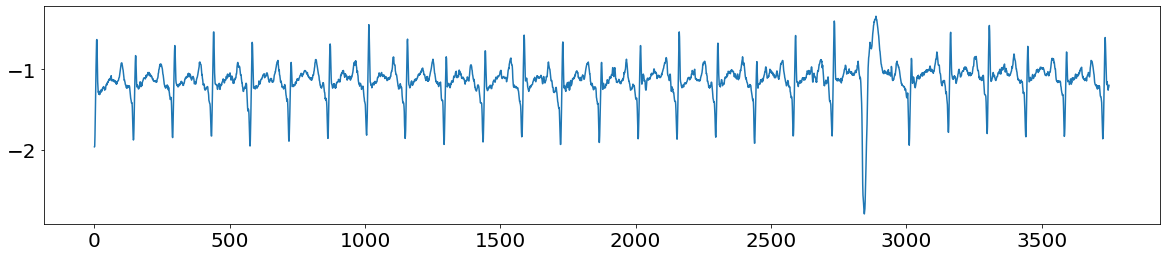

In [8]:
# 表示
fig = plt.figure(figsize=(20,4))
plt.tick_params(labelsize=20, color="black")
plt.plot(x)

# いろいろ関数作るよ

# 基本設定

In [10]:
# 変数の確認
# x : 1次元のndarray

# 関数部分

In [94]:
# スペトログラムのグラフ表示
def Graph_freq(x_leng, sr, tmp, title="Spectrogram"):   
    # グラフ表示用の軸設定
    # left : 0[s], right : max_time[s]
    # bottom : 0[Hz], top : max_freq [Hz]
    max_time = x_leng // sr
    max_freq = sr // 2 
    extent = [0, max_time, 0, max_freq]
    
    # 対数振幅スペクトログラムをグラフ表示
    plt.figure(figsize=[30, 6])
    ax = plt.subplot()
    im = plt.imshow(tmp, aspect="auto", extent=extent)
    ax.set_title(title, size=16)
    ax.set_xlabel('Time [s]', size=14)
    ax.set_ylabel('Frequency [Hz]', size=14)
    cbar = plt.colorbar(im, format='%+2.0f dB', aspect=100)
    cbar.set_label("Magnitude [dB]", size=14)
    plt.show()    

In [95]:
# STFTの実行
def STFT_run(x, window=1024, step=512, sr=48000, win_fc=1.):
    """docs : STFT(numpy)
    ========================================
    params :
    x : 1dim-ndarray or same like data
    window : window size (Partial time series)
    step : Number of samples for overlap
    win_fc : window function (example : Hanning or Rectangura or etc...)
    ========================================
    returns :
    Z_tmp : Complex matrix
    Z_amp : Amplitude spectrum matrix
    Z_pow : Power spectrum matrix
    
    """
    # 複素行列の
    Z_tmp = []
    
    # numpy.FFTを連続的に適応する処理
    for i in range((x.shape[0] - window) // step):
        # 部分時系列に対して、窓関数を適応
        tmp = x[i*step : i*step + window]* win_fc
        
        # numpyFFTの実行 : optionのnormに"ortho"を指定すると、1/√tmpで正規化する
        # 返り値は複素数配列
        tmp = np.fft.fft(tmp, n=None, norm=None)  # get fft data [i*step:i*step+window]
        
        # 振幅スペクトルを計算
        #tmp = np.abs(tmp)
        # パワースペクトルの計算（振幅スペクトルの二乗）
        #fftpow = fftamp ** 2
        
        # 各配列をリストに格納(遅いかもだから、リストへの代入法にしたい)
        Z_tmp.append(tmp)

        
    # ndarrayに変換
    Z_tmp = np.array(Z_tmp)
    print("STFT内、複素数行列形状は：", str(Z_tmp.shape))
    
    Z_tmp = np.abs(Z_tmp.T)[window // 2:]
    print("STFT内、振幅スペクトル形状は：", str(Z_tmp.shape))
    
    # パワースペクトルに変換
    Z_pow = Z_tmp ** 2
    print("STFT内、パワースペクトル形状は：", str(Z_pow.shape))
    
    # 対数スペクトログラム化している : 20 * np.log10
    # 振幅スペクトルに変換している : np.abs(Z_tmp.T)
    # ナイキスト周波数の処理をスライシングで実行 : [window // 2:]
    #Z_tmp = 20 * np.log10(np.abs(Z_tmp.T))[window // 2:]
    Z_tmp = 20 * np.log10(Z_tmp)
    print("STFT内、対数振幅スペクトル形状は：", str(Z_tmp.shape))
    
    return Z_tmp, Z_pow

# 周波数分析の実行部分

対象データの形状は (3750,)
STFT内、複素数行列形状は： (109, 256)
STFT内、振幅スペクトル形状は： (128, 109)
STFT内、パワースペクトル形状は： (128, 109)
STFT内、対数振幅スペクトル形状は： (128, 109)
34.403669724770644


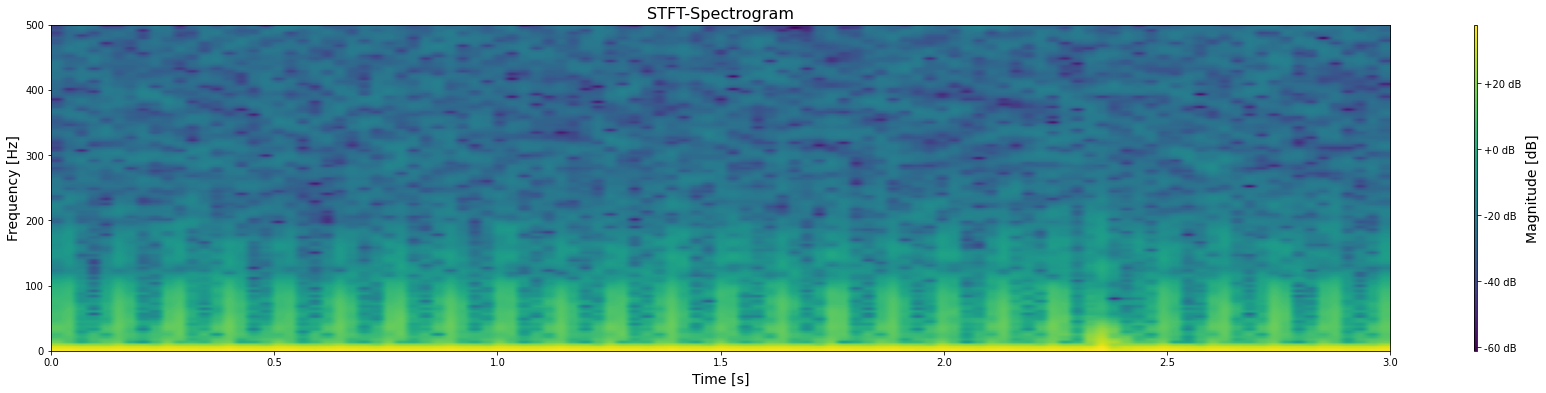

In [99]:
# 返り値は、(周波数軸, 時間軸(bin))、且つ、周波数軸は0が一番高周波数になる
print("対象データの形状は", str(x.shape))

# 基本設定(データによって異なる)
window = 256
step = 32
sr = 1000

# 窓関数を指定する
#win_fc = signal.hamming(window)              # とりあえず使う
win_fc = signal.flattop(window)              # ピーク値を正確に取りたい
#win_fc = signal.kaiser(window, beta=14)       # 非常に近い周波数を分離したい
#win_fc = signal.chebwin(window, at=100)      # ダイナミックレンジを大きくしたい
    
# STFT結果の取得
Z_tmp, Z_pow = STFT_run(x, window, step, sr, win_fc)
print(x.shape[0] / Z_tmp.shape[1])

# グラフ表示
Graph_freq(x.shape[0], sr, Z_tmp, title="STFT-Spectrogram")

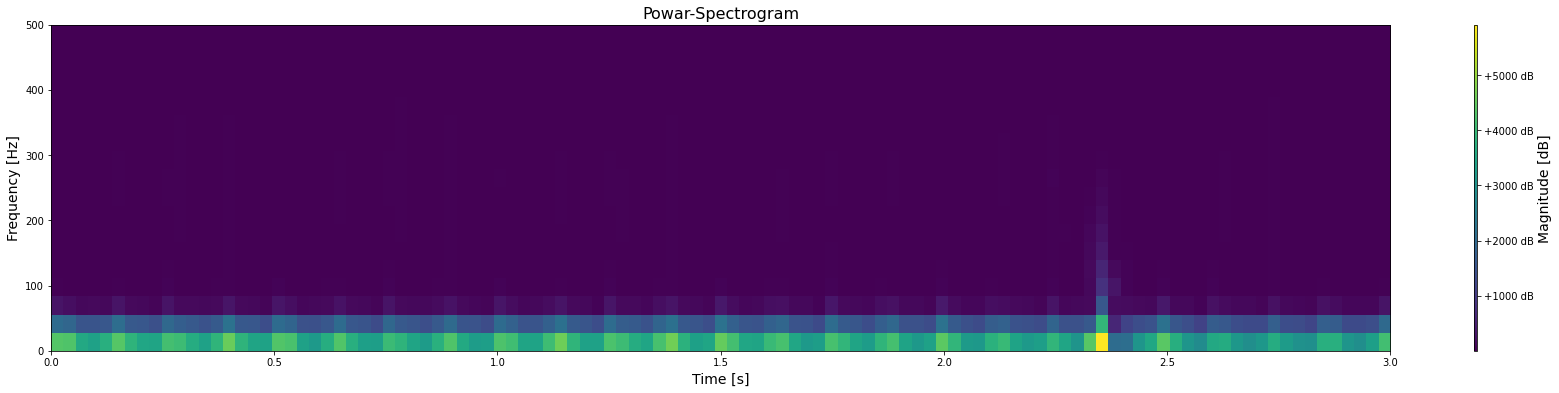

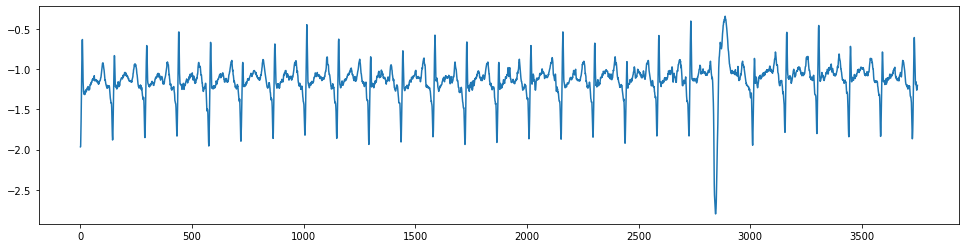

In [101]:
# グラフ表示_パワースペクトル
Graph_freq(x.shape[0], sr, Z_pow[110:], title="Powar-Spectrogram")

# 元データと重ね合わせる
plt.figure(figsize=[16.5, 4])
plt.plot(x)


# pywaveletによる

In [102]:
# 登録されているウェーブレット名のリストを取得する
wavlist = pywt.wavelist(kind='continuous')
print(list(wavlist))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


In [ ]:
# waveletのメモ
# URL：https://pywavelets.readthedocs.io/en/latest/ref/cwt.html
# 
# mexh : メキシカンハットウェーブレット, 一定の前線は正規化係数であるため、ウェーブレットは単位エネルギーを持つ
# morl : モーレットウェーブレット"morl"
# cmor : 複素Morletウェーブレット（"cmorB-C"浮動小数点値B、C）, B は帯域幅であり、 C は中心周波数
# cgau : 複素ガウスウェーブレット（"cgauP"Pは1〜8の整数）は、関数のP次導関数,C  は次数に依存する正規化定数
# shan : シャノンウェーブレット（"shanB-C"浮動小数点値BおよびC), Bは帯域幅, Cは中心周波数
# fpsp : 周波数Bスプラインウェーブレット（"fpspM-B-C"整数Mおよび浮動小数点B、C）M  スプライン順序です、 B は帯域幅であり、 C は中心周波数

In [ ]:
# 作ったけど、B、C、P、Mには何か数字を入れる必要がある

dict_waveret ={0 : "mexh",
               1 : "morl",
               2 : "cmorB-C",
               3 : "gausP",
               4 : "cgauP",
               5 : "shanB-C",
               6 : "fpspM-B-C",
               7 : "cmor1.5-1.0"
              } 

In [103]:
%%time
#wave, fs = wav_read(path_to_wavfile)
# サンプリングレート
fs = 1000

# マザーウェーブレットのタイプ
#wavelet_type = wavlist[8]+"1.5-0.75"
num = 18
print(wavlist[num])
wavelet_type = wavlist[num]

# ウェーブレット変換に用いる単位[Hz]を行列作成しておく
#scale = np.arange(1,257)
scale = np.arange(1,65)

# 1次元連続ウェーブレット変換の実行
coef, _ = pywt.cwt(x, scales=scale, wavelet=wavelet_type)


t = np.arange(len(x))/fs

frq = pywt.scale2frequency(scale=scale, wavelet=wavelet_type)*fs

mexh
Wall time: 26.4 ms


c:\users\kushi\python_venv\02_torch\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


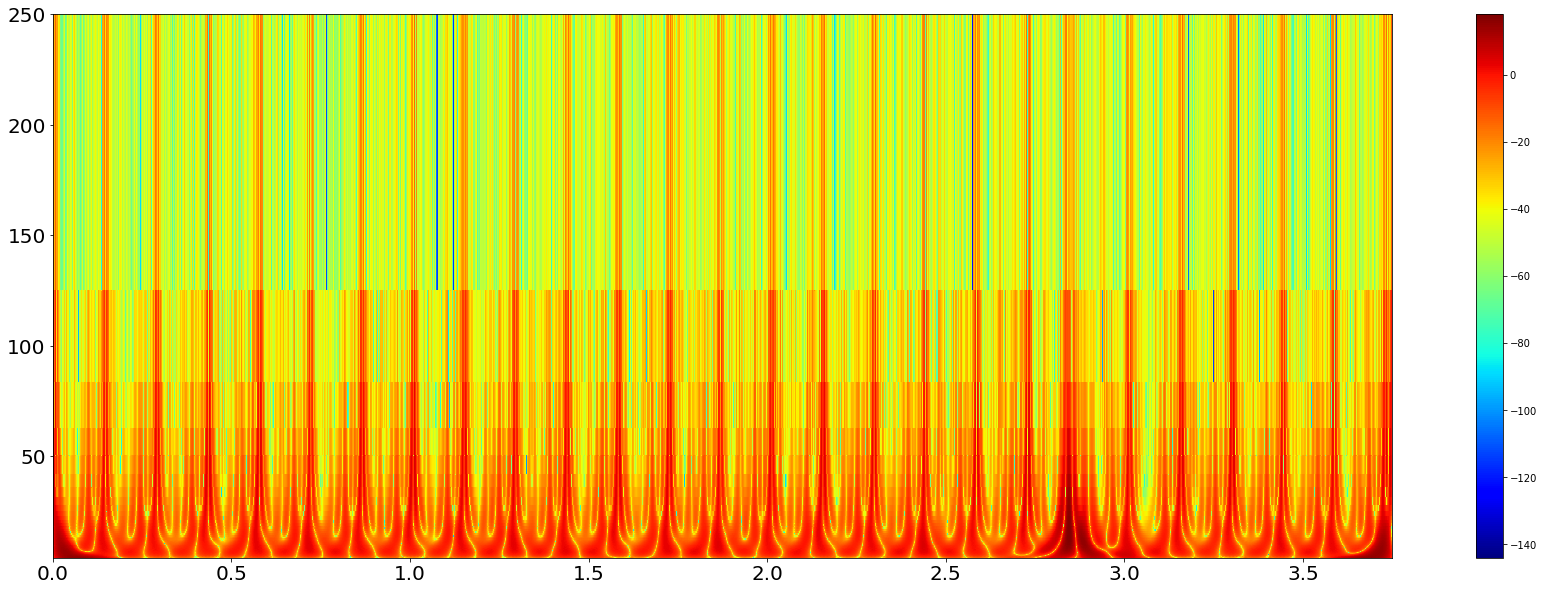

In [104]:
fig = plt.figure(figsize=(30,10))
plt.tick_params(labelsize=20, color="black")

plt.pcolormesh(t, frq, 10 * np.log(np.abs(coef)), cmap="jet")
plt.colorbar()
plt.show()
plt.close()

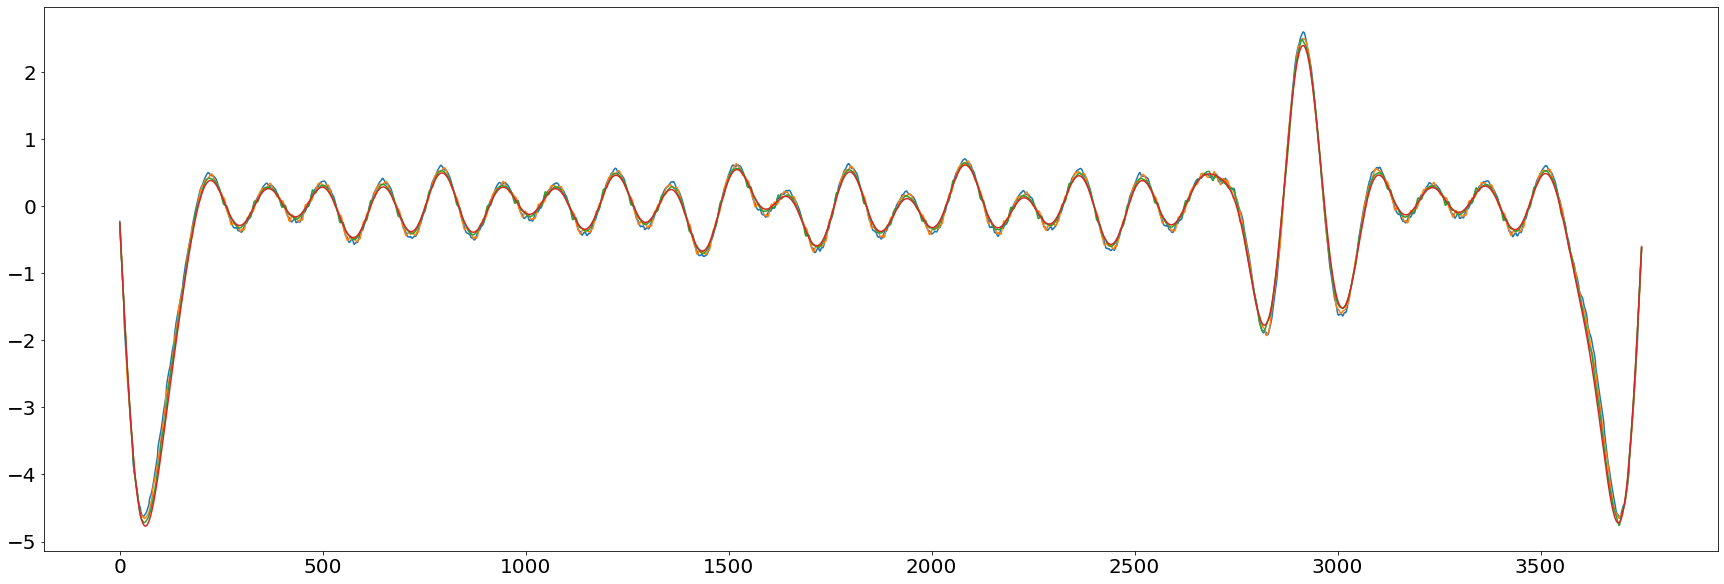

In [106]:
# 限定的に表示
co = coef[60:,:]

fig = plt.figure(figsize=(30,10))
plt.tick_params(labelsize=20, color="black")
plt.plot(co.T)